# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


# Data Overview

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv').set_index('id')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv').set_index("id")
orig_data = pd.read_csv("/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv")
train.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [3]:
orig_data.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,32,51,41,Red,Ground Nuts,7,3,19,14-35-14
1,35,58,35,Black,Cotton,4,14,16,Urea
2,27,55,43,Sandy,Sugarcane,28,0,17,20-20
3,33,56,56,Loamy,Ground Nuts,37,5,24,28-28
4,32,70,60,Red,Ground Nuts,4,6,9,14-35-14


In [4]:
train = pd.concat([train, orig_data], ignore_index=True)

In [5]:
test.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
id,,,,,,,,
750000,31,70,52,Sandy,Wheat,34,11,24
750001,27,62,45,Red,Sugarcane,30,14,15
750002,28,72,28,Clayey,Ground Nuts,14,15,4
750003,37,53,57,Black,Ground Nuts,18,17,36
750004,31,55,32,Red,Pulses,13,19,14


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850000 entries, 0 to 849999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      850000 non-null  int64 
 1   Humidity         850000 non-null  int64 
 2   Moisture         850000 non-null  int64 
 3   Soil Type        850000 non-null  object
 4   Crop Type        850000 non-null  object
 5   Nitrogen         850000 non-null  int64 
 6   Potassium        850000 non-null  int64 
 7   Phosphorous      850000 non-null  int64 
 8   Fertilizer Name  850000 non-null  object
dtypes: int64(6), object(3)
memory usage: 58.4+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Temparature  250000 non-null  int64 
 1   Humidity     250000 non-null  int64 
 2   Moisture     250000 non-null  int64 
 3   Soil Type    250000 non-null  object
 4   Crop Type    250000 non-null  object
 5   Nitrogen     250000 non-null  int64 
 6   Potassium    250000 non-null  int64 
 7   Phosphorous  250000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 17.2+ MB


In [8]:
train.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,850000.000000,850000.000000,850000.000000,850000.000000,850000.000000,850000.000000
mean,31.503534,61.032665,45.162887,23.081215,9.477581,21.066198
std,4.024909,6.648149,11.799929,11.219842,5.765965,12.352064
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [9]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


# Data Analysis & Visualization

## Numerical Features

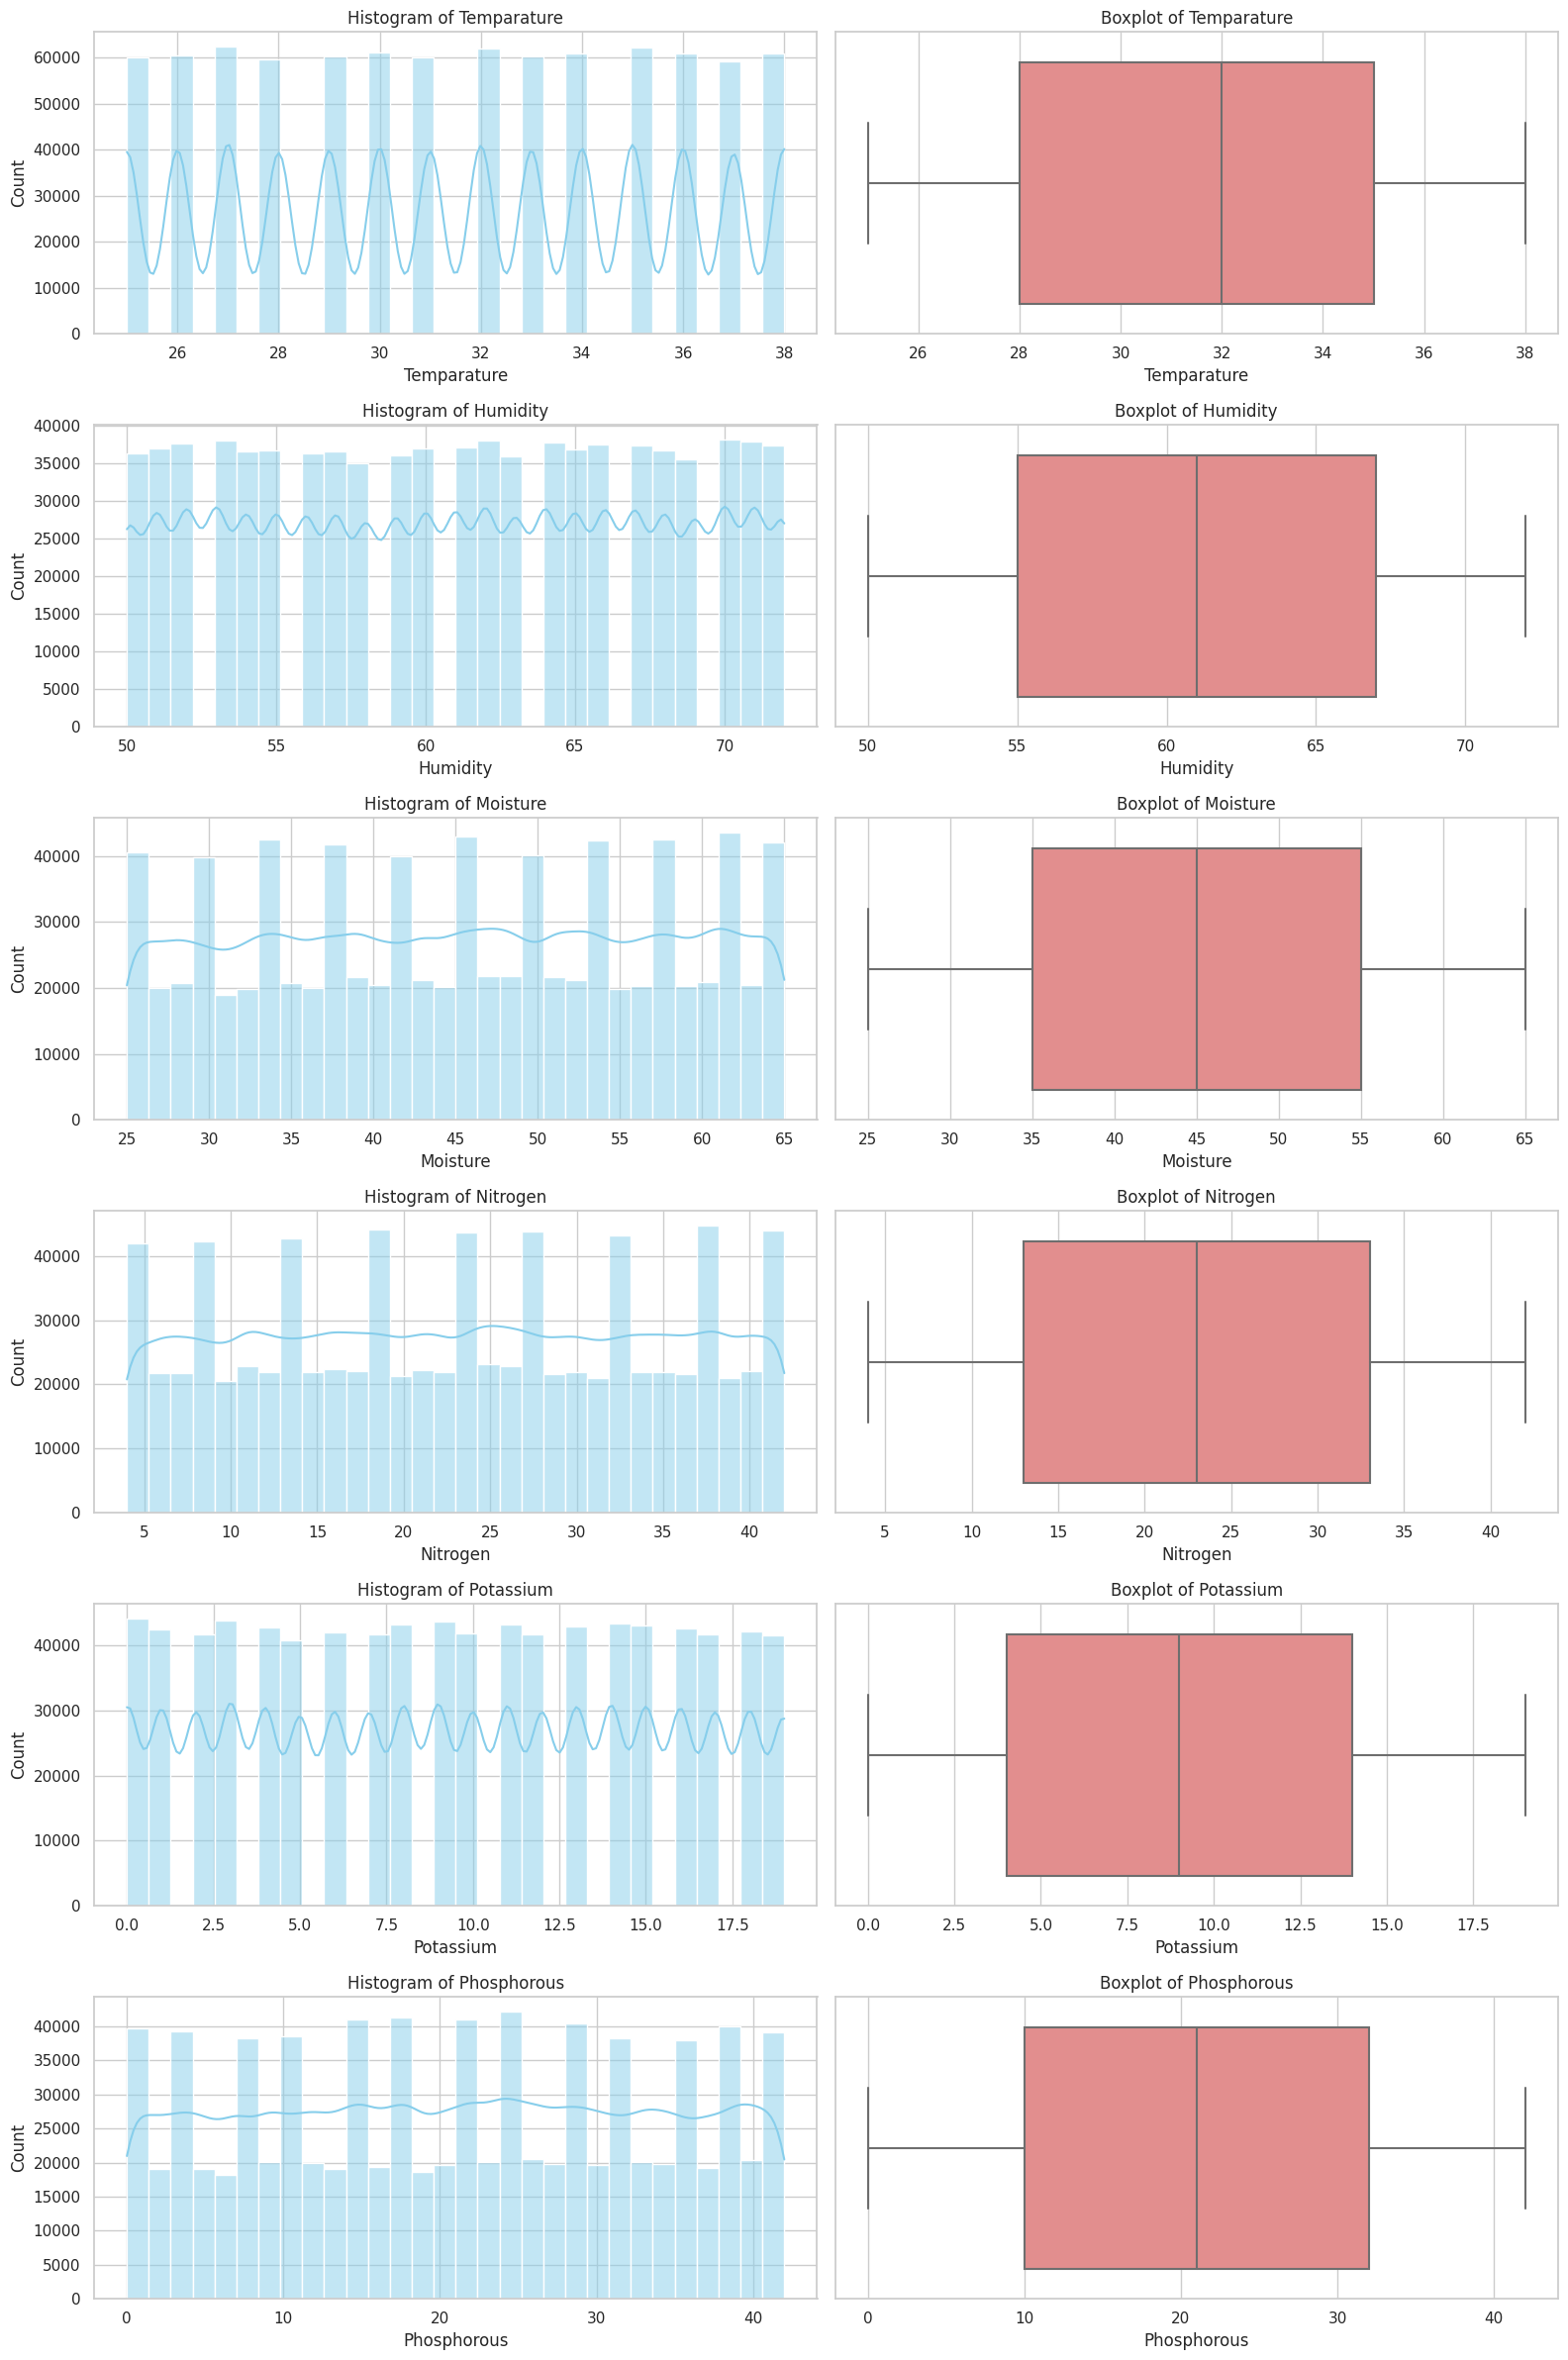

In [10]:
# Select only numerical columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 24))

# Plot histograms
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, i * 2 + 1)
    sns.histplot(train[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    
    plt.subplot(len(numerical_cols), 2, i * 2 + 2)
    sns.boxplot(x=train[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


## Categorical Features

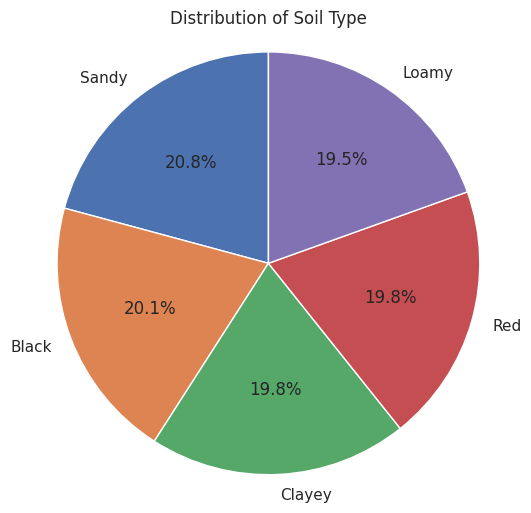

Number of Unique Soil Type: 5


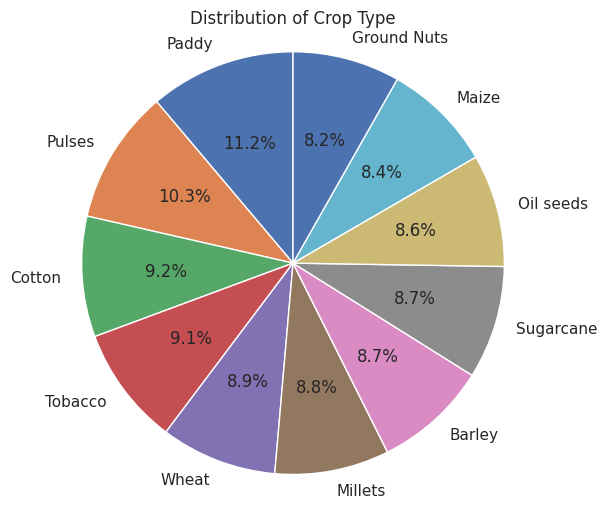

Number of Unique Crop Type: 11


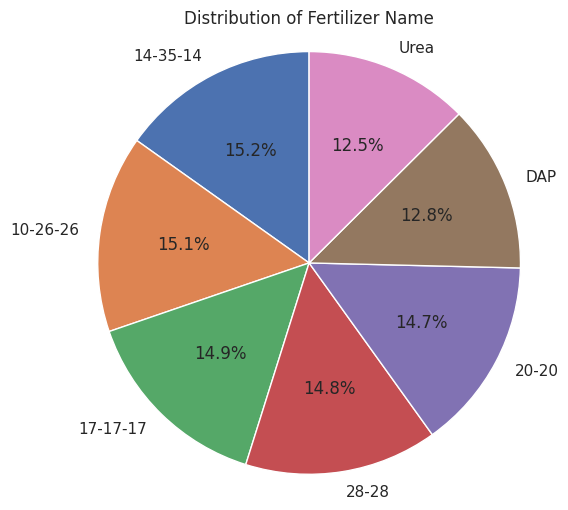

Number of Unique Fertilizer Name: 7


In [11]:
for feature in ["Soil Type", "Crop Type",'Fertilizer Name']:
    counts = train[feature].value_counts()

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"Distribution of {feature}")
    plt.axis("equal")
    plt.show()

    # Print unique and missing values
    print(f"Number of Unique {feature}: {train[feature].nunique()}")

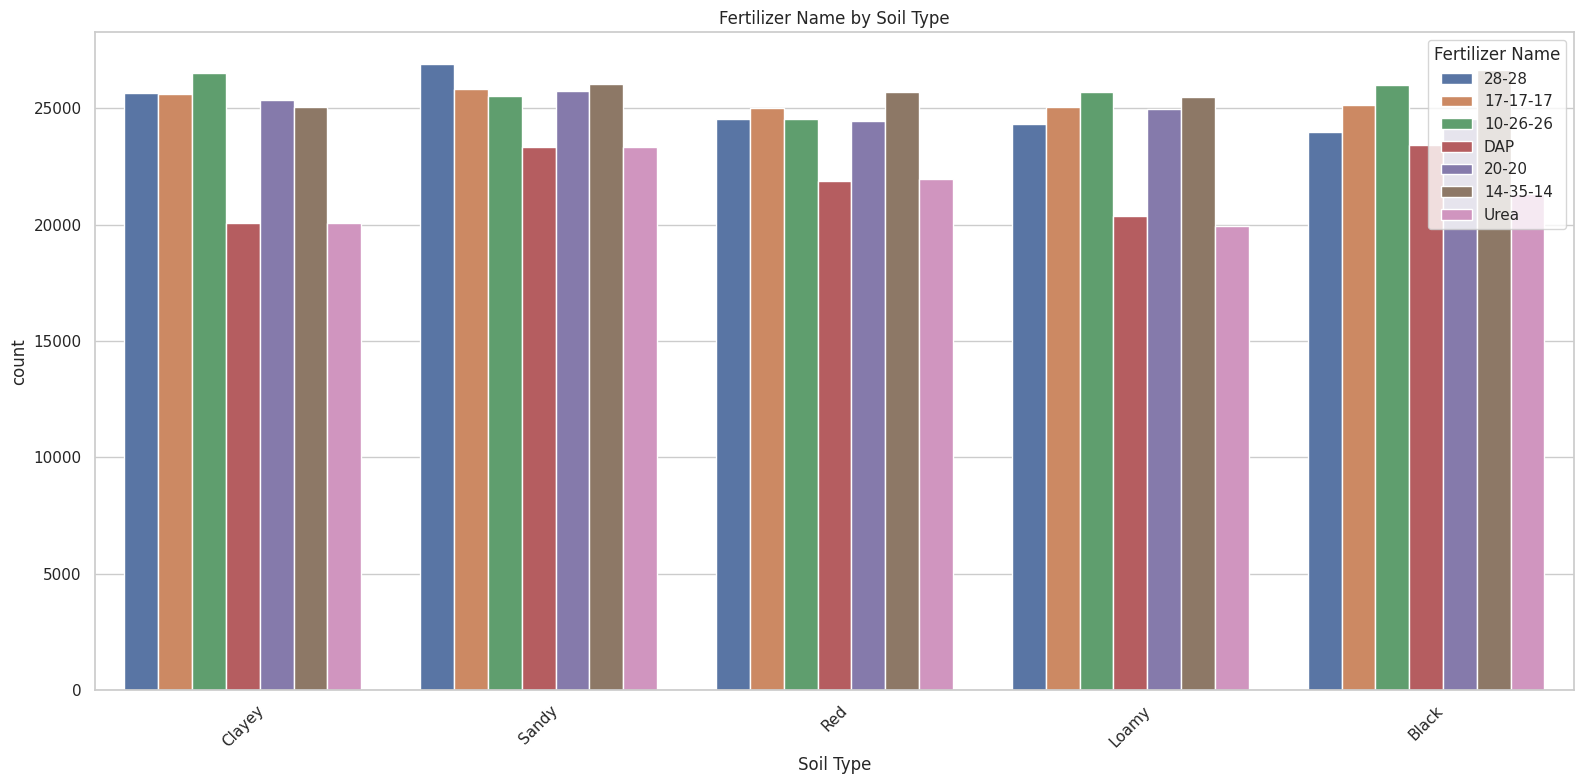

In [12]:
plt.figure(figsize=(16, 8))

# Soil Type vs Fertilizer Name
sns.countplot(x='Soil Type', hue='Fertilizer Name', data=train)
plt.title('Fertilizer Name by Soil Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


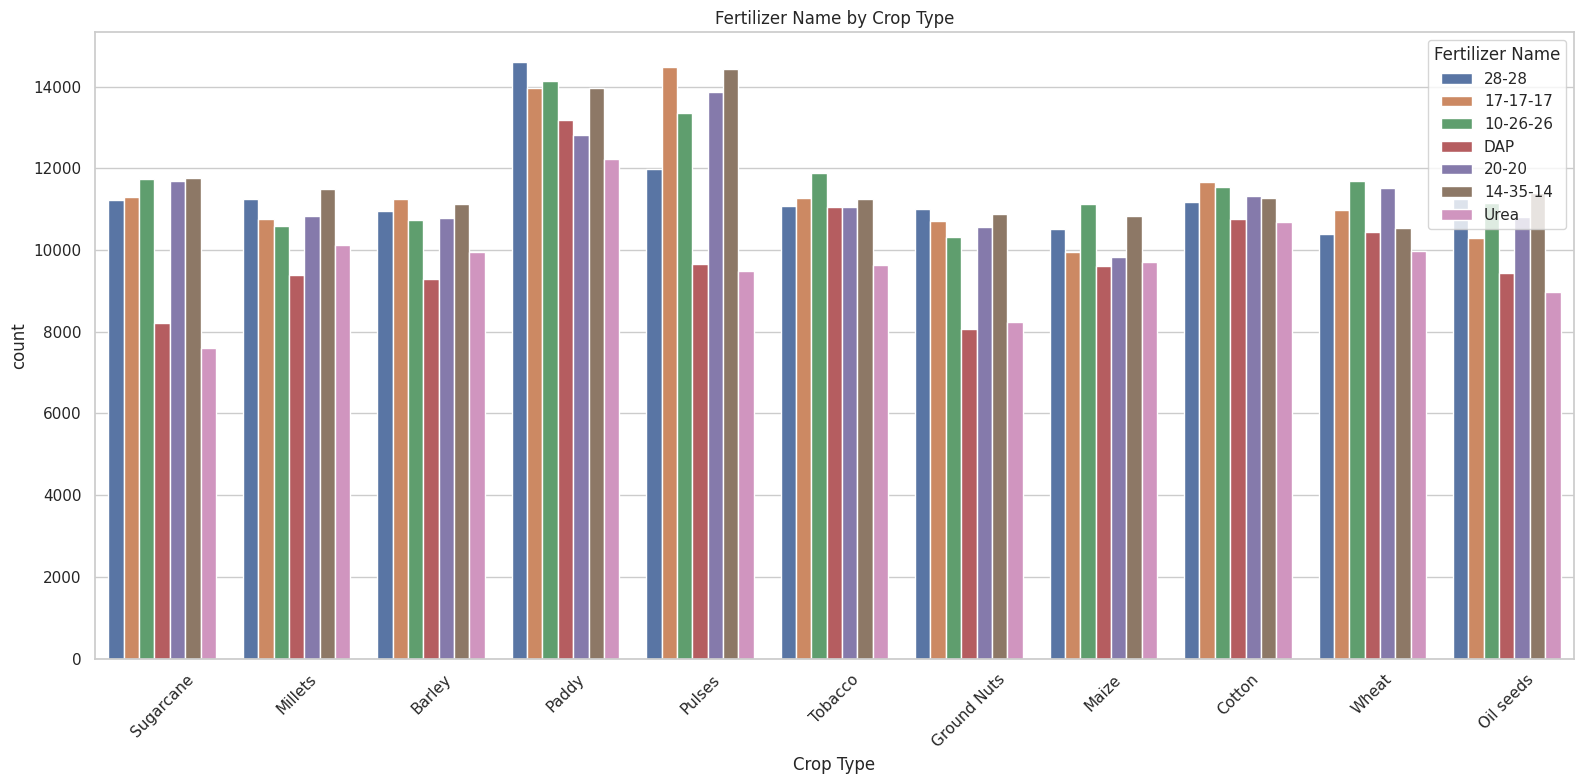

In [13]:
plt.figure(figsize=(16, 8))
# Crop Type vs Fertilizer Name
sns.countplot(x='Crop Type', hue='Fertilizer Name', data=train)
plt.title('Fertilizer Name by Crop Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

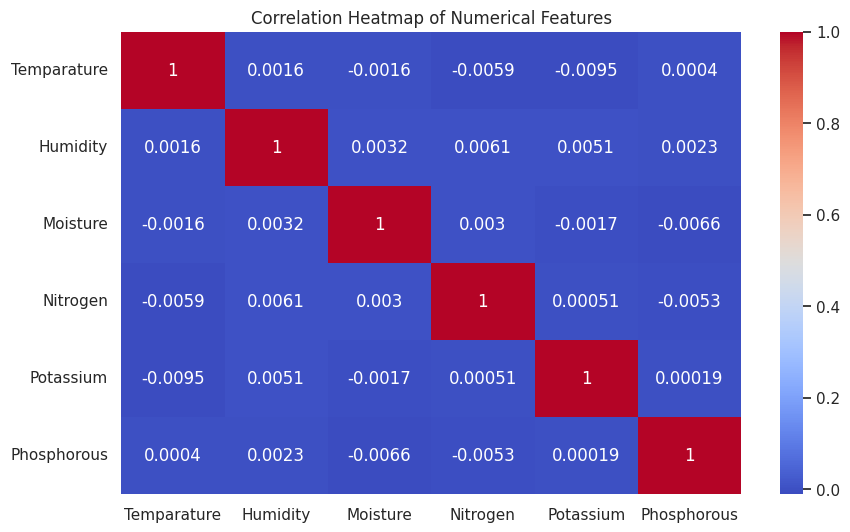

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(train[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


In [15]:
train.groupby('Fertilizer Name')[numerical_cols].mean().style.background_gradient(cmap='YlGnBu')


,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
Fertilizer Name,,,,,,
10-26-26,31.472600,60.938877,45.069754,23.188056,9.549425,20.979324
14-35-14,31.541209,60.959939,45.093285,23.070559,9.483223,21.392568
17-17-17,31.464727,60.997402,44.748975,23.184466,9.521651,21.046342
20-20,31.513976,61.099640,45.281954,23.004350,9.584033,21.096250
28-28,31.518430,61.002089,45.461273,23.004538,9.477056,21.020289
DAP,31.507297,61.142629,45.225935,23.146966,9.267602,20.954162
Urea,31.507661,61.120187,45.295550,22.956049,9.422573,20.933019


# Feature Preprocessing & Engineering

In [16]:
# def engineer_features(df):
#     df = df.copy()

#     df['Temp_bin'] = pd.cut(df['Temparature'], bins=[0, 20, 30, 40, 50], labels=['Low', 'Moderate', 'High', 'Extreme'], include_lowest=True)
#     df['Humidity_bin'] = pd.cut(df['Humidity'], bins=[0, 30, 60, 100], labels=['Dry', 'Normal', 'Humid'], include_lowest=True)

#     #df['Soil_Crop'] = df['Soil Type'].astype(str) + "_" + df['Crop Type'].astype(str)

#     #df = pd.get_dummies(df, columns=['Temp_bin', 'Humidity_bin', 'Soil_Crop'], drop_first=True)

#     return df


In [17]:
# train = engineer_features(train)
# test = engineer_features(test)

# train = train.drop(columns=['Temparature','Humidity'],axis=1)
# test = test.drop(columns=['Temparature','Humidity'],axis=1)

In [18]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# Feature Encoding
cat_cols = train.select_dtypes(include=['object','category']).columns.drop('Fertilizer Name')
oe = OrdinalEncoder()
train[cat_cols] = oe.fit_transform(train[cat_cols])
test[cat_cols] = oe.transform(test[cat_cols])

# Encoding
le = LabelEncoder()
train['Fertilizer Name'] = le.fit_transform(train['Fertilizer Name'])

In [19]:
for df in [train, test]:
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int16')
        elif df[col].dtype == 'float64':
            df[col]= df[col].astype('float16')

# Model building & evaluation

In [20]:
import xgboost as xgb
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

X = train.drop('Fertilizer Name', axis=1)
y = train['Fertilizer Name']

def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        p = p[:k]
        score = 0.0
        hits = 0
        seen = set()
        for i, pred in enumerate(p):
            if pred in a and pred not in seen:
                hits += 1
                score += hits / (i + 1.0)
                seen.add(pred)
        return score / min(len(a), k)
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


xgb_model = XGBClassifier(
    max_depth=17,
    colsample_bytree=0.467,
    subsample=0.86,
    n_estimators=10000,
    learning_rate=0.03,
    gamma=0.26,
    max_delta_step=4,
    reg_alpha=2.7,
    reg_lambda=1.4,
    early_stopping_rounds=100,
    objective='multi:softprob',
    random_state=13,
    enable_categorical=True,
    tree_method='hist',     
    device='cuda'           
)  



FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(shape = (len(train) ,y.nunique()))
pred_prob = np.zeros(shape = (len(test),y.nunique()))


for i, (train_idx, valid_idx) in enumerate(skf.split(X,y)):
    print('#' * 15, i+1, '#' *15)
    x_train, x_valid = X.iloc[train_idx],X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx],y.iloc[valid_idx]

    xgb_model.fit(x_train,y_train, eval_set=[(x_valid,y_valid)],verbose = 0)
    oof[valid_idx] = xgb_model.predict_proba(x_valid)
    pred_prob +=xgb_model.predict_proba(test)

    top_3_preds = np.argsort(oof[valid_idx], axis=1)[:, -3:][:, ::-1]  
    actual = [[label] for label in y_valid]
    map3_score = mapk(actual, top_3_preds)
    print(f" FOLD {i+1}: MAP@3 Score: {map3_score:.5f}")

############### 1 ###############
 FOLD 1: MAP@3 Score: 0.37289
############### 2 ###############
 FOLD 2: MAP@3 Score: 0.37153
############### 3 ###############
 FOLD 3: MAP@3 Score: 0.37298
############### 4 ###############
 FOLD 4: MAP@3 Score: 0.37076
############### 5 ###############
 FOLD 5: MAP@3 Score: 0.37146
############### 6 ###############
 FOLD 6: MAP@3 Score: 0.37407
############### 7 ###############
 FOLD 7: MAP@3 Score: 0.37201
############### 8 ###############
 FOLD 8: MAP@3 Score: 0.37126
############### 9 ###############
 FOLD 9: MAP@3 Score: 0.37055
############### 10 ###############
 FOLD 10: MAP@3 Score: 0.37006


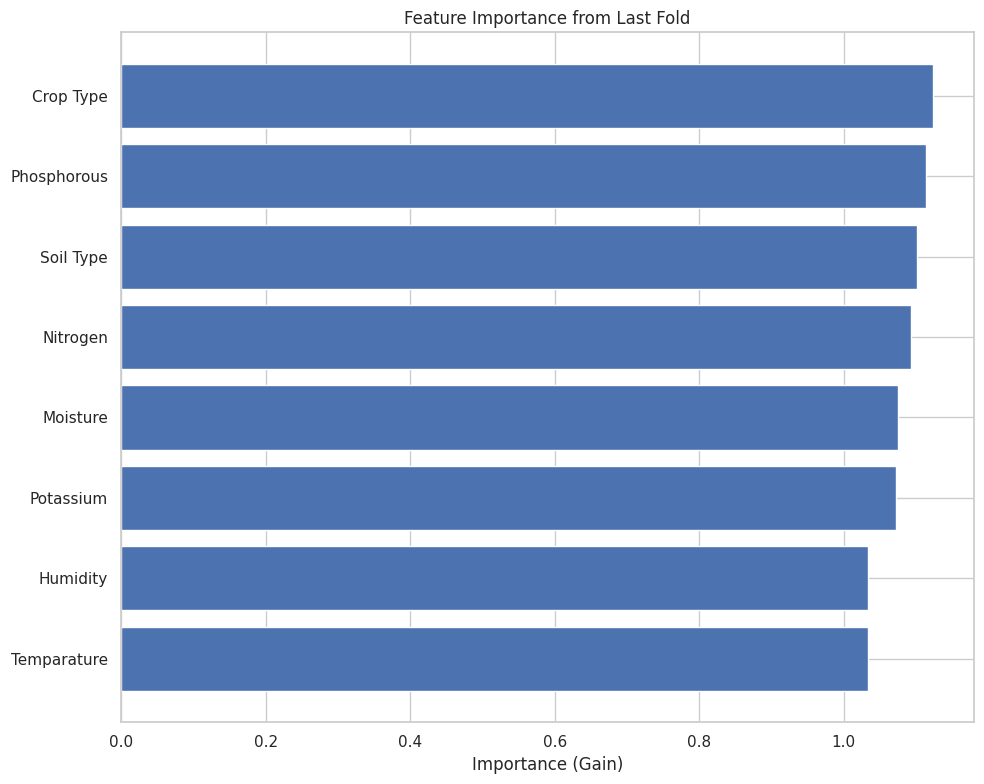

In [21]:
importance = xgb_model.get_booster().get_score(importance_type='gain')  


importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance (Gain)')
plt.title('Feature Importance from Last Fold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [22]:
top_k_indices = np.argsort(pred_prob, axis=1)[:, -3:][:, ::-1]  
top_k_labels = le.inverse_transform(top_k_indices.ravel()).reshape(top_k_indices.shape)

sample_sub = pd.read_csv("/kaggle/input/playground-series-s5e6/sample_submission.csv")

submission = pd.DataFrame({
    'id': sample_sub['id'],
    'Fertilizer Name': [' '.join(row) for row in top_k_labels]
})

submission.to_csv('submission.csv', index=False)
submission.head()


,id,Fertilizer Name
0,750000,10-26-26 DAP 20-20
1,750001,17-17-17 10-26-26 20-20
2,750002,20-20 28-28 Urea
3,750003,14-35-14 DAP 17-17-17
4,750004,Urea 20-20 10-26-26
